In [164]:
import cv2
import matplotlib.pyplot as plt
import csv
import numpy as np

from tensorflow.keras.backend import shape, arange, tile, expand_dims, flatten, transpose, stack, reshape, cast, dtype, maximum, minimum
from tensorflow import concat, constant, newaxis, ones, function, Tensor, random


In [27]:
def yolo_head(feats):
    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    print(conv_dims)
    conv_height_index = arange(0, stop=conv_dims[0])
    print(f'{conv_height_index=}')
    conv_width_index = arange(0, stop=conv_dims[1])
    print(f'{conv_width_index=}')
    conv_height_index = tile(conv_height_index, [conv_dims[1]])
    print(f'{conv_height_index=}')
    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index =tile(
        expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    print(f'{conv_width_index=}')
    conv_width_index = flatten(transpose(conv_width_index))
    print(f'{conv_width_index=}')
    conv_index = transpose(stack([conv_height_index, conv_width_index]))
    print(f'{conv_index=}')
    conv_index = reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    print(f'{conv_index=}')
    conv_index = cast(conv_index, dtype(feats))

    conv_dims = cast(reshape(conv_dims, [1, 1, 1, 1, 2]), dtype(feats))
    print(f'{conv_dims=}')

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh

In [39]:
# fea = ones(shape=(1, 7, 7, 1, 4))
# print(yolo_head(fea))
label = constant([[[0, 0], [1, 1]]])
y = constant([[[1, 1], [2, 2]]])
print(maximum(label, y))

tf.Tensor(
[[[1 1]
  [2 2]]], shape=(1, 2, 2), dtype=int32)


In [2]:
pic = cv2.cvtColor(cv2.imread('0.png'), cv2.COLOR_BGR2RGB)

def show_pic(pic: np.ndarray, rectangle: list[int] = None, dian = None):
    _ = plt.figure()
    pic_w, pic_h, _ = pic.shape
    vlines = np.linspace(0, pic_w, 8)
    hlines = np.linspace(0, pic_h, 8)
    plt.imshow(pic)

    if rectangle:
        ax = plt.gca()
        ax.add_patch(plt.Rectangle(rectangle[:2],
                                   rectangle[2] - rectangle[0],
                                   rectangle[3] - rectangle[1], color="blue",
                                   fill=False, linewidth=1))
    plt.hlines(hlines, min(vlines), max(vlines), colors='.25', linewidth=.75)
    plt.vlines(vlines, min(hlines), max(hlines), colors='.25', linewidth=.75)
    if dian:
        plt.scatter(dian[0], dian[1], s=1, c="blue", alpha=0.8)
    plt.show()

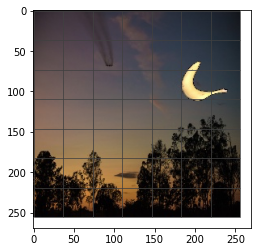

In [3]:
show_pic(pic)

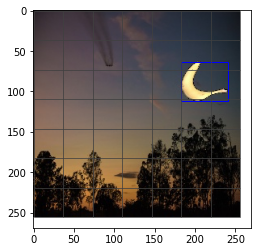

In [4]:
with open('label.csv', 'r') as f:
    data = csv.reader(f.readlines())
_ = next(data)
data0 = next(data)
x_min, y_min, x_max, y_max = map(lambda x: int(x), data0[-4:])
show_pic(pic, [x_min, y_min, x_max, y_max])

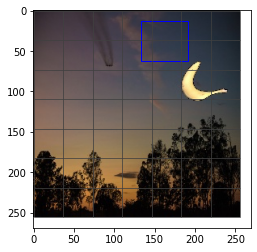

In [5]:
fake_rect = list(map(lambda x: x - 50, (x_min, y_min, x_max, y_max)))
show_pic(pic, fake_rect)

In [6]:
def get_iou(t1 ,t2):
    minnn = np.minimum(t1 ,t2)
    maxxx = np.maximum(t1 ,t2)
    j_area = (maxxx[0] - minnn[2]) * (maxxx[1] - minnn[3])
    b_area = ((minnn[3] - minnn[1]) * (minnn[2] - minnn[0]) - j_area) + (maxxx[3] - maxxx[1]) * (maxxx[2] - maxxx[0])
    print(j_area, b_area)
get_iou([133, 13, 191, 62], [190, 61, 255, 72])

1 3556


222.5 66.5
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1.]]
14.0 0.083984375
(1, 7, 7, 30)


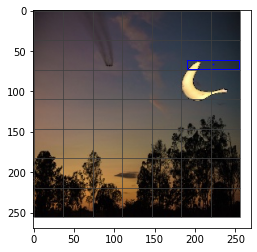

In [7]:
a = np.zeros(shape=(1, 49, 30))
b = [190, 61, 255, 72]
size_x = 7
size_y = 7
image = cv2.cvtColor(cv2.imread('0.png'), cv2.COLOR_BGR2RGB)
step_x = image.shape[0] / size_x
step_y = image.shape[1] / size_y
center_x = b[0] + (b[2] - b[0]) / 2
center_y = b[1] + (b[3] - b[1]) / 2
print(center_x, center_y)
cell_num = (center_x // step_x + 1) + (center_y // step_y * 7)
a[:, int(cell_num), :] = [1] * 30
print(a[:, int(cell_num), :])
print(cell_num, center_x / step_x - (center_x // step_x))
print(np.reshape(a, (-1, 7, 7, 30)).shape)
show_pic(pic, [190, 61, 255, 72], [center_x, center_y])

In [8]:

a = constant([[[[1, 2], [3, 4]], [[1, 2], [3, 4]]]])
b = constant([[[[1, 2], [3, 4]], [[1, 2], [3, 4]]]])
print(a.shape)

(1, 2, 2, 2)


In [5]:

from tensorflow import shape, reshape
from tensorflow.keras.layers import LeakyReLU, Activation, Conv2D, MaxPooling2D, Input, BatchNormalization, Flatten, Dense, concatenate, Softmax
from tensorflow.keras.models import Sequential, Model

In [8]:
class Tiny_YOLO:
    def __init__(self, cls_num: int, input_shape: tuple = (224, 224, 3)):
        """
        紧凑型yolov1

        :param cls_num: 类别数目
        :param input_shape: 输入形状
        """
        self._input_shape = input_shape
        self._cls_num = cls_num

    def get_yolo(self):
        def get_yolo_block(filters_list: list):
            _layers = []
            for filters in filters_list:
                _layers.append(Conv2D(filters=filters, kernel_size=(3, 3), strides=2, padding="same"))
                _layers.append(BatchNormalization())
                _layers.append(LeakyReLU(0.1))
                _layers.append(MaxPooling2D(pool_size=(3, 3), padding="same"))
            return _layers

        def output_reshape(_output: Tensor):
            _size_x, _size_y = 7, 7
            bounding_box = 2
            bbox_idx = bounding_box * 4
            confidence_idx = bbox_idx + bounding_box
            # bounding_box
            bbox = reshape(_output[:, :bbox_idx],
                           (shape(_output)[0], _size_x, _size_y, bbox_idx))
            bbox = Activation('sigmoid')(bbox)
            # confidence
            conf = reshape(_output[:, bbox_idx:confidence_idx],
                           (shape(_output)[0], _size_x, _size_y, bounding_box))
            conf = Activation('sigmoid')(conf)
            # cls
            cls = reshape(_output[:, confidence_idx:],
                          (shape(_output)[0], _size_x, _size_y, self._cls_num))
            if self._cls_num > 1:
                cls = Softmax()(cls)
            else:
                cls = Activation('sigmoid')(cls)
            return concatenate([bbox, conf, cls], axis=-1)

        x = Input(shape=self._input_shape)
        main_block = Sequential(get_yolo_block([64, 128, 256]))
        y = main_block(x)
        y = Flatten()(y)
        y = Dense(7 * 7 * 30, activation='linear')(y)
        output = output_reshape(y)
        return Model(x, output)

In [9]:
yolo = Tiny_YOLO(cls_num=1).get_yolo()
yolo.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2, 2, 256)    372608      input_3[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 1024)         0           sequential_2[0][0]               
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1470)         1506750     flatten_2[0][0]                  
____________________________________________________________________________________________

In [144]:
def get_box_xc_xy_wh(raw_bounding_box: Tensor) -> tuple[Tensor, Tensor]:
    """
    网络输出的x,y,w,h,均为相对于一个网格来说的，在[0, 1]之间

    :param raw_bounding_box: 网络的bounding_box输出(形状为(batch_size, height, width, bounding_box_num, 4))
    :return:
    """
    size = shape(raw_bounding_box)[1:3]  # 首先获取网格大小
    # 生成网格行索引
    conv_height_index = arange(0, size[0], dtype="float32")
    # 生成网格列索引
    conv_width_index = arange(0, size[1], dtype="float32")

    # 将网格行索引按列扩展为列倍(有行*列个初始的左上角坐标)
    conv_height_index = tile(conv_height_index, [size[1]])
    # 将网格列索引按行扩展为行倍(有行*列个初始的左上角坐标)
    conv_width_index = tile(expand_dims(conv_width_index, 0), [size[0], 1])
    # [[0, 1], [1, 2]] -> [0, 1, 1, 2]
    conv_width_index = flatten(transpose(conv_width_index))

    # 按最后一维整合（[0, 1, 2, 0, 1, 2], [0, 0, 1, 1, 2, 2,] -> [[0, 0], [1, 0], ...]）
    conv_index = stack((conv_height_index, conv_width_index), axis=-1)
    # 转换为输入特征图形状（即7*7个像素点有各自对应的左上角坐标，方便求出实际的框大小）
    conv_index = reshape(conv_index, (1, size[0], size[1], 1, 2))  # (1, 7, 7, 1, 2)
    # 形状维度转换
    size = cast(reshape(size, (1, 1, 1, 1, 2)), dtype="float32")  # 方便计算

    # 将中心点映射回真实坐标
    box_xc_yc = (raw_bounding_box[..., :2] + conv_index) / size * 448
    box_wh = raw_bounding_box[..., 2:4] * 448
    return box_xc_yc, box_wh  # (batch_size, h, w, bounding_box_num, 2), (batch_size, h, w, bounding_box_num, 2)


In [ ]:
def get_xy_min_max(box_x_y: Tensor, box_wh: Tensor) -> tuple[Tensor, Tensor]:
    """
    由真实中心点和宽高获取左上角xy和右下角xy

    :param box_x_y: 真实中心点
    :param box_wh: 真实宽高
    :return:
    """
    xy_max = box_x_y + box_wh / constant(2.)
    xy_min = box_x_y - box_wh / constant(2.)
    return xy_min, xy_max

def get_iou(pred_xy_min: Tensor, pred_xy_max: Tensor,
            true_xy_min: Tensor, true_xy_max: Tensor) -> Tensor:
    # 取真实框和预测框相交的左上点
    min_xy = maximum(pred_xy_min, true_xy_min)
    # 取真实框和预测框相交的右下点
    max_xy = minimum(pred_xy_max, true_xy_max)
    # 相交宽度和高度
    intersect_height_width = maximum(max_xy - min_xy, 0.)
    # 相交区域面积
    intersect_area = intersect_height_width[..., 0] * intersect_height_width[..., 1]

    # 计算真实框面积
    true_wh = true_xy_max - true_xy_min
    true_area = true_wh[..., 0] * true_wh[..., 1]

    # 计算预测框真实面积
    pred_wh = pred_xy_max - pred_xy_min
    pred_area = pred_wh[..., 0] * pred_wh[..., 1]

    # 返回iou
    return intersect_area / (true_area + pred_area - intersect_area)
